<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/Sleep-Quality-Based-EEG-Signals/blob/main/1_Sleep_Quality_SlpEDF_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Systems for Sleep Quality Assessment Based on EEG Signals

---

* **Author**: Carmen-Theodora Craciun
* **Status**: Done
* **The purpose of this Notebook**: This notebook handles the *downloading, organization and viewing* of the files provided by the two studies.
* **Previos step**: None
* **Dataset**: [Sleep-EDFX Database (PhysioNet)](https://www.physionet.org/content/sleep-edfx/1.0.0/)
  * **Studies used:**
    * Sleep Cassette (SC) - the study on healthy people
    * Sleep Telemetry (ST) - sleep study in people with difficulty falling asleep. This study was designed to look at the effects of temazepam, a drug with hypnotic effects.
* **Input**: A text file with the credentials for logging into the [PyshioNet]* **Output**:
  * 4 folders:
    * SC_healthy_hypno (153 EDF files) - hypnogram files of the SC study
    * SC_healthy_psg (153 EDF files) - PSG files of the SC study
    * ST_insomnia_hypno (44 EDF files)
    * ST_insomnia_psg (44 EDF files)
  * full_paths.csv - A csv containing the columns:
    * id - the unique id of each patient in the study
    * psg_path - the path to the patient's PSG file
    * hypno_path - the path to the patient's hypnogram file
    * study - the study to which the recording belongs

#Instalation and importing

In [1]:
!pip install mne pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.9 MB/s eta 0:00:00


In [2]:
import os
import re
import csv
import mne
import time
import urllib3
import requests
import datetime
import pyedflib
import warnings
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_path = '/content/drive/MyDrive/sleep_data/raw_dataset'

#Connect

In [ ]:
def upload_credentials():
  '''
  Upload the credentials for PyshioNet.
  Return:
   - the username and password (str).
  '''
  print("Upload the file with username and password (first line: username, second line: password)")
  uploaded = files.upload()

  for filename in uploaded.keys():
      with open(filename, 'r') as f:
          lines = f.read().splitlines()
          if len(lines) >= 2:
              username = lines[0].strip()
              password = lines[1].strip()
              return username, password
          else:
              raise ValueError("File must contain at least two lines: username and password")

from google.colab import files
username, password = upload_credentials()

print(f"Username: {username}")
print("Password: [PROTECTED]")

Upload the file with username and password (first line: username, second line: password)


Saving disertatie.txt to disertatie.txt
Username: carmen-theodora
Password: [PROTECTED]


#Download

In [ ]:
class SleepEdFxDownloader:
    def __init__(self, username, password, base_path):
        self.auth = (username, password)
        self.base_url = "https://physionet.org/files/sleep-edfx/1.0.0/"

        self.base_path = base_path

        self.headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        self.study_urls = [
            "https://physionet.org/content/sleep-edfx/1.0.0/sleep-cassette/",
            "https://physionet.org/content/sleep-edfx/1.0.0/sleep-telemetry/"
        ]

        self.directories = [
            os.path.join(base_path, 'SC_healthy_psg'),
            os.path.join(base_path, 'SC_healthy_hypno'),
            os.path.join(base_path, 'ST_insomnia_psg'),
            os.path.join(base_path, 'ST_insomnia_hypno')
        ]

        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    def __get_all_files_from_studies(self):
      '''Get all files from both studies.

      Return:
        - A list of all files.
      '''
      all_files = []
      for url in self.study_urls:
          response = requests.get(url)
          response.raise_for_status()
          soup = BeautifulSoup(response.text, 'html.parser')

          for link in soup.find_all('a', href=True):
              href = link['href']
              if href.endswith(('.edf', '.hypnogram')):
                  all_files.append(href)

      print(f"Found {len(all_files)} total files to download")
      return all_files

    def __get_file_info(self,filename):
      '''Get the type and study for the file.

      Return:
        - study where the file belongs
        - output path
        - file type
      '''
      is_psg = 'PSG' in filename
      is_hypno = 'Hypnogram' in filename

      if filename.startswith('SC'):
          subfolder = "sleep-cassette"
          if is_psg:
              return "sleep-cassette", f"{self.base_path}/SC_healthy_psg", "psg"
          elif is_hypno:
              return "sleep-cassette", f"{self.base_path}/SC_healthy_hypno", "hypno"
      elif filename.startswith('ST'):
          subfolder = "sleep-telemetry"
          if is_psg:
              return "sleep-telemetry", f"{self.base_path}/ST_insomnia_psg", "psg"
          elif is_hypno:
              return "sleep-telemetry", f"{self.base_path}/ST_insomnia_hypno", "hypno"

      return None, None, None

    def __check_file_exist(self, filename, output_path, file_type, downloaded_list):
        ''' Check if the file already exists.'''
        if os.path.exists(output_path):
            file_size = os.path.getsize(output_path)
            min_size = 1000000 if file_type == "psg" else 1000

            if file_size > min_size:
                downloaded_list.append(filename)
                return True

        return False

    def __check_file_size(self, downloaded_list, filename, output_path, file_type, failed_list):
        ''' Check if the file has the correct size.'''
        if not os.path.exists(output_path):
            failed_list.append(filename)
            return False

        file_size = os.path.getsize(output_path)

        min_size = 1000000 if file_type == "psg" else 1000

        if file_size > min_size:
            downloaded_list.append(filename)
            return True
        else:
            os.remove(output_path)
            failed_list.append(filename)
            return False

    def download_files(self):
        '''Main method to execute the logic.'''
        # Get the list of the files
        file_list = self.__get_all_files_from_studies()

        # Create directory if not exist
        os.makedirs(self.base_path, exist_ok=True)
        for directory in self.directories:
            os.makedirs(directory, exist_ok=True)

        downloaded = []
        failed = []

        print(f"Starting check/download process for {len(file_list)} files...")

        for idx, filename in enumerate(file_list):
            # Get the output_dir for the file
            subfolder, output_dir, file_type = self.__get_file_info(filename)

            if subfolder is None:
                continue

            output_path = os.path.join(output_dir, filename)

            # Check if the file exist
            if self.__check_file_exist(filename, output_path, file_type, downloaded):
                continue

            # If not download the file
            url = f"{self.base_url}{subfolder}/{filename}"

            try:
                print(f"Downloading {filename}...")
                # Request to PhysioNet
                response = requests.get(url, auth=self.auth, headers=self.headers, timeout=60, verify=False, stream=True)

                if response.status_code != 200:
                    print(f"HTTP {response.status_code} for {filename}")
                    failed.append(filename)
                    continue

                # Write the file
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)

                if not self.__check_file_size(downloaded, filename, output_path, file_type, failed):
                    print(f"Validation Failed: {filename}")

            except Exception as e:
                print(f"Error downloading {filename}: {str(e)}")
                failed.append(filename)

        print(f"\n=== SUMMARY ===")
        print(f"Total files (existing + downloaded): {len(downloaded)}")
        print(f"Failed downloads: {len(failed)}")

        return downloaded, failed

In [ ]:
try:
    downloader = SleepEdFxDownloader(username, password,base_path)
    downloaded, failed = downloader.download_files()
except Exception as e:
    print(f"Download process failed: {e}")
    downloaded, failed = [], []

Found 394 total files to download
Starting check/download process for 394 files...

=== SUMMARY ===
Total files (existing + downloaded): 394
Failed downloads: 0


#File listing

In [ ]:
def get_edf_files(directory):
  '''
  Get all EDF files from the specified directory.

  Parameters:
    - directory (str): The path to the directory containing EDF files.

  Returns:
    - list: A list of paths to all EDF files found in the directory.
  '''
  edf_files = []
  for root, dirs, files in os.walk(directory):
      for file in files:
          if file.endswith('.edf'):
              edf_files.append(os.path.join(root, file))
  return edf_files

In [ ]:
def load_edf_files(base_path):
  '''
  Load all EDF files from specified directories.

  Parameters:
    - base_path (str): The path to the directory containg the dataset.

  Returns:
    - dict: A dictionary containing the paths to all PSG and Hypnogram files.
  '''
  print("=== LOADING EDF FILES ===")

  paths = {
      'healthy_psg': os.path.join(base_path, 'SC_healthy_psg'),
      'healthy_hypno': os.path.join(base_path, 'SC_healthy_hypno'),
      'insomnia_psg': os.path.join(base_path, 'ST_insomnia_psg'),
      'insomnia_hypno': os.path.join(base_path, 'ST_insomnia_hypno')
  }

  for name, path in paths.items():
      if not os.path.exists(path):
          print(f"X {name}: Path not found - {path}")

  files = {}
  for dataset_type in ['healthy', 'insomnia']:
      psg_path = paths[f'{dataset_type}_psg']
      hypno_path = paths[f'{dataset_type}_hypno']

      psg_files = get_edf_files(psg_path)
      hypno_files = get_edf_files(hypno_path)

      files[f'{dataset_type}_psg'] = psg_files
      files[f'{dataset_type}_hypno'] = hypno_files

      print(f"{dataset_type.title()}:")
      print(f"  PSG files: {len(psg_files)}")
      print(f"  Hypnogram files: {len(hypno_files)}")

  return files

In [ ]:
files = load_edf_files(base_path + 'raw_dataset/')

=== LOADING EDF FILES ===
X healthy_psg: Path not found - /content/drive/MyDrive/sleep_data/raw_datasetraw_dataset/SC_healthy_psg
X healthy_hypno: Path not found - /content/drive/MyDrive/sleep_data/raw_datasetraw_dataset/SC_healthy_hypno
X insomnia_psg: Path not found - /content/drive/MyDrive/sleep_data/raw_datasetraw_dataset/ST_insomnia_psg
X insomnia_hypno: Path not found - /content/drive/MyDrive/sleep_data/raw_datasetraw_dataset/ST_insomnia_hypno
Healthy:
  PSG files: 0
  Hypnogram files: 0
Insomnia:
  PSG files: 0
  Hypnogram files: 0


#Match PSG with hypnogram files

In [ ]:
def create_matched_dataframe(psg_files, hypno_files, dataset_name):
    '''Match PSG files with corresponding hypnogram files.
    The names are in the pattern (s = our string)
      - s[0] = S
      - s[1] in (C,T), the study
      - s[2:6] same numbers
      - s[7-8] different letters for the same match
      - s[9] = -
      - s[10:] = PSG or Hyponogram
    Only s[0:6] is matched for the files

    Parameters:
      - psg_files (list): List of paths to PSG files.
      - hypno_files (list): List of paths to hypnogram files.
      - dataset_name (str): Name of the dataset.

    Returns:
      - pd.DataFrame: A DataFrame containing matched PSG and hypnogram file paths.
    '''

    print(f"=== MATCHING {dataset_name.upper()} FILES ===")

    def extract_id(filename):
        return os.path.basename(filename)[0:6]

    # 1. Create dictionaries
    psg_dict = {extract_id(f): f for f in psg_files}
    hypno_dict = {extract_id(f): f for f in hypno_files}

    # 2. Identify the sets of IDs
    psg_ids = set(psg_dict.keys())
    hypno_ids = set(hypno_dict.keys())

    # 3. Find the intersection (matches) and differences (unmatched)
    matched_ids = sorted(list(psg_ids.intersection(hypno_ids)))
    unmatched_psg = psg_ids - hypno_ids
    unmatched_hypno = hypno_ids - psg_ids

    # 4. Print statistics (for verification)
    print(f"Matched pairs: {len(matched_ids)}")
    print(f"Unmatched PSG files: {len(unmatched_psg)}")
    print(f"Unmatched hypnogram files: {len(unmatched_hypno)}")

    if unmatched_psg:
        print("Example unmatched PSG:", list(unmatched_psg)[:5])
    if unmatched_hypno:
        print("Example unmatched Hypno:", list(unmatched_hypno)[:5])
    print("-" * 30)

    # 5. Build the data list for the DataFrame
    data = []
    for file_id in matched_ids:
        data.append({
            'id': file_id,
            'psg_path': psg_dict[file_id],
            'hypno_path': hypno_dict[file_id]
        })

    return pd.DataFrame(data)

In [ ]:
healthy_matched_df = create_matched_dataframe(files['healthy_psg'], files['healthy_hypno'],'SC (healthy)')
insomnia_matched_df = create_matched_dataframe(files['insomnia_psg'], files['insomnia_hypno'], 'ST (insomnia)')

print("\nHealthy Matched DataFrame Head:")
display(healthy_matched_df.head())

#Inspect hypnogram

In [ ]:
def inspect_hypno_file(hypno_path, enable_prints=True):
    '''Inspect a hypnogram EDF file and print basic information about its annotations.

    Parameters:
        - hypno_path (str): Path to the hypnogram EDF file.
        - enable_prints (bool): Whether to print details to the console.

    Returns:
        - list: A list containing problematic file paths (if any errors occur).
    '''
    problematic_files_local = []

    try:
        # Try to open the file as an EDF (European Data Format) using pyedflib
        with pyedflib.EdfReader(hypno_path) as edf:
            if enable_prints:
                print(f"=== EDF Info for {os.path.basename(hypno_path)} ===")
                print(f"Channels: {edf.getSignalLabels()}")  # EDF channel labels (usually empty for hypnogram files)

            # Read annotations (sleep stage intervals)
            annotations = edf.readAnnotations()
            if enable_prints:
                print(f"Number of annotations: {len(annotations[0])}")
                if len(annotations[0]) > 0:
                    # Show first few annotations (start time, duration, stage)
                    print(f"First few annotations: {list(zip(annotations[0][:5], annotations[1][:5], annotations[2][:5]))}")

    except Exception as e:
        # If EDF reading fails, mark file as problematic
        problematic_files_local.append(hypno_path)
        if enable_prints:
            print(f"EDF read error: {e}")

        # Try to open the file as plain text (sometimes mislabeled files are text)
        try:
            with open(hypno_path, 'r') as f:
                content = f.read()
            if enable_prints:
                print(f"Text content (first 500 chars): {content[:500]}")
        except Exception as e2:
            if enable_prints:
                print(f"Text read error: {e2}")

    return problematic_files_local

In [ ]:
# Inspecting only the first 5 hypno files with prints
for path in healthy_matched_df['hypno_path'].head(5):
  inspect_hypno_file(path)

# Inspecting the all list of hypnograms to see where are problems
healthy_problematic_files = []
for path in healthy_matched_df['hypno_path']:
  healthy_problematic_files.extend(inspect_hypno_file(path, enable_prints=False))

print()
if len(healthy_problematic_files) > 0:
  print("The problematic files are: ",healthy_problematic_files)
else:
  print("No problematic files found in all dataset")

=== EDF Info for SC4001EC-Hypnogram.edf ===
Channels: []
Number of annotations: 154
First few annotations: [(np.float64(0.0), np.float64(30630.0), np.str_('Sleep stage W')), (np.float64(30630.0), np.float64(120.0), np.str_('Sleep stage 1')), (np.float64(30750.0), np.float64(390.0), np.str_('Sleep stage 2')), (np.float64(31140.0), np.float64(30.0), np.str_('Sleep stage 3')), (np.float64(31170.0), np.float64(30.0), np.str_('Sleep stage 2'))]
=== EDF Info for SC4002EC-Hypnogram.edf ===
Channels: []
Number of annotations: 152
First few annotations: [(np.float64(0.0), np.float64(26070.0), np.str_('Sleep stage W')), (np.float64(26070.0), np.float64(90.0), np.str_('Sleep stage 1')), (np.float64(26160.0), np.float64(510.0), np.str_('Sleep stage 2')), (np.float64(26670.0), np.float64(270.0), np.str_('Sleep stage 3')), (np.float64(26940.0), np.float64(1140.0), np.str_('Sleep stage 4'))]
=== EDF Info for SC4011EH-Hypnogram.edf ===
Channels: []
Number of annotations: 126
First few annotations: [(n

In [ ]:
for path in insomnia_matched_df['hypno_path'].head(5):
  inspect_hypno_file(path)

insomnia_problematic_files = []
for path in insomnia_matched_df['hypno_path']:
  insomnia_problematic_files.extend(inspect_hypno_file(path, enable_prints=False))

print()
if len(insomnia_problematic_files) > 0:
  print("The problematic files are: ",insomnia_problematic_files)
else:
  print("No problematic files found in all dataset")

=== EDF Info for ST7011JP-Hypnogram.edf ===
Channels: []
Number of annotations: 231
First few annotations: [(np.float64(0.0), np.float64(1560.0), np.str_('Sleep stage W')), (np.float64(1560.0), np.float64(90.0), np.str_('Sleep stage 1')), (np.float64(1650.0), np.float64(570.0), np.str_('Sleep stage 2')), (np.float64(2220.0), np.float64(120.0), np.str_('Sleep stage 1')), (np.float64(2340.0), np.float64(60.0), np.str_('Sleep stage 2'))]
=== EDF Info for ST7012JP-Hypnogram.edf ===
Channels: []
Number of annotations: 173
First few annotations: [(np.float64(0.0), np.float64(660.0), np.str_('Sleep stage W')), (np.float64(660.0), np.float64(240.0), np.str_('Sleep stage 1')), (np.float64(900.0), np.float64(60.0), np.str_('Sleep stage 2')), (np.float64(960.0), np.float64(30.0), np.str_('Sleep stage 1')), (np.float64(990.0), np.float64(840.0), np.str_('Sleep stage 2'))]
EDF read error: /content/drive/MyDrive/sleep_data/raw_dataset/ST_insomnia_hypno/ST7021JM-Hypnogram.edf: the file is not EDF(+) 

What do we understand from the results?

1. Annotation Structure - all files (except the failed one) show a very similar annotation structure

* **Channels: []** - EDF files contain only annotations/markers (sleep stages), not actual physiological signals (EEG, EOG, etc.).
* Number of annotations: Varies between 99 and 199, reflecting the duration and fragmentation of sleep of individual recordings.
* First few annotations: = The format is a tuple of type:
  * $(T_{start}, T_{duration}, Stage)$
  * $T_{start}$ = The start time of the stage (in seconds from the start of the recording)
  * $T_{duration}$ = The duration of this stage (in seconds)
  * Stage = The name of the stage (e.g. 'Sleep stage W', 'Sleep stage 1', 'Sleep stage 2').
* Note: The basic duration of sleep epochs in sleep studies is 30 seconds. Many of the annotated durations (e.g. 24390.0, 210.0, 30.0, 240.0) are multiples of 30 seconds. This confirms that both datasets use 30-second slice-based annotation, even though the annotations are condensed as intervals (a single row for multiple consecutive slices of the same stage).

#Analyze the problematic hypno files

In [ ]:
def analyze_problematic_file(file_path):
    '''Analyze a problematic hypnogram file to determine its type and validity.

    Parameters:
        - file_path (str): Path to the problematic file.

    Returns:
        - dict: A dictionary with metadata about the file.
    '''
    result = {
        "file": file_path,
        "actual_type": "Unknown",
        "is_valid_edf": False,
        "content_preview": "",
        "error_message": ""
    }

    try:
        # Try to open as text file (ASCII hypnogram)
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            head = [next(f).strip() for _ in range(5)]  # Read first 5 lines
            content_preview = "; ".join(head)

            # If content resembles sleep stage annotations, classify as TXT/ASCII
            if any(x in content_preview for x in ['Sleep stage', 'M ', 'W', '1', '2', '3', '4', 'R']):
                result["actual_type"] = "TXT / ASCII"
                result["content_preview"] = content_preview
                return result

    except Exception:
        pass  # Ignore text read errors, continue with EDF check

    try:
        # Try to read as EDF using MNE
        mne.io.read_annotations(file_path)
        result["actual_type"] = "Valid EDF"
        result["is_valid_edf"] = True
        result["content_preview"] = "Header OK"
    except Exception as e:
        # If EDF parsing fails, mark as corrupt
        result["actual_type"] = "Corrupt EDF / Binary"
        result["error_message"] = str(e)

        try:
            # Read first 20 bytes in binary mode to preview header
            with open(file_path, 'rb') as f:
                header_bytes = f.read(20)
                result["content_preview"] = f"HEX: {header_bytes}"
        except:
            pass

    return result

data_list = []
for p_file in insomnia_problematic_files:
    if os.path.exists(p_file):
        data_list.append(analyze_problematic_file(p_file))
    else:
        data_list.append({"file": p_file, "actual_type": "FILE NOT FOUND", "error_message": "Path incorrect"})

df_problems = pd.DataFrame(data_list)
display(df_problems)

,file,actual_type,is_valid_edf,content_preview,error_message
0,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
1,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
2,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
3,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
4,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
5,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations
6,/content/drive/MyDrive/sleep_data/raw_dataset/...,Corrupt EDF / Binary,False,HEX: b'0 X X X X ',No mne.io attribute read_annotations


The problem is that, most likely, **the files were saved as text** (ASCII) and the binary headers got corrupted, which is why pyedflib (which expects a strict binary format) gives an error. But the data is there so we can fix it.

In [ ]:
def repair_hypno(filepath):
    '''Repairs a corrupt or text-based Hypnogram EDF file by extracting annotations via regex and regenerating a valid EDF+ file using MNE-Python.

    Parameters:
        filepath (str): Full path to the problematic .edf file.

    Returns:
        bool: True if repair was successful, False otherwise.
    '''
    filename = os.path.basename(filepath)
    print(f"Processing: {filename}")

    # 1. The file is read as bytes to handle potential binary corruption.
    # We filter out non-printable ASCII characters (keeping only code points 32-126) to ensure the regex engine can process the text content.
    try:
        with open(filepath, 'rb') as f:
            raw_bytes = f.read()

        clean_bytes = bytearray()
        for b in raw_bytes:
            if 32 <= b <= 126:
                clean_bytes.append(b)
            else:
                # Replace non-printable chars with a space
                clean_bytes.append(32)

        normalized_content = clean_bytes.decode('latin-1')
    except Exception as e:
        print(f"Error reading file: {e}")
        return False

    # 2. We attempt to find the recording start date and time in the header text.
    # Default to Jan 1, 2000, if parsing fails.
    start_date = datetime.datetime(2000, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
    try:
        # Regex to find date pattern like "Startdate 01-JAN-1990"
        date_match = re.search(r'Startdate\s+(\d{2}-[A-Z]{3}-\d{4})', normalized_content, re.IGNORECASE)
        if date_match:
            d_str = date_match.group(1)
            # Regex to find time pattern like "12.30.00" near the date
            time_match = re.search(r'(\d{2})\.(\d{2})\.(\d{2})', normalized_content[date_match.end():date_match.end()+50])
            h, m, s = time_match.groups() if time_match else (0,0,0)

            # Construct the datetime object
            dt_str = f"{d_str} {h}:{m}:{s}"
            dt_obj = datetime.datetime.strptime(dt_str, "%d-%b-%Y %H:%M:%S")
            start_date = dt_obj.replace(tzinfo=datetime.timezone.utc)
    except Exception as e:
        print(f"  [!] Date parsing warning: {e}. Using default date.")

    # 3. This regex looks for patterns like: "+0.0  30.0  Sleep stage W"
    # Group 1: Onset, Group 2: Duration, Group 3: Description
    pattern = r'\+(\d+(?:\.\d+)?)[^\d\+]+(\d+(?:\.\d+)?)[^\w]+(Sleep stage [W1234R]|Movement time)'
    matches = re.findall(pattern, normalized_content)

    if not matches:
        print(f"Error: No annotations found in the text content.")
        return False

    onsets = []
    durations = []
    descriptions = []

    for m in matches:
        onsets.append(float(m[0]))
        durations.append(float(m[1]))
        descriptions.append(m[2])

    print(f"  -> Extracted data: {len(onsets)} annotations.")

    # 4. Create a backup of the original file before overwriting.
    backup_path = filepath + ".bak"
    if not os.path.exists(backup_path):
        os.rename(filepath, backup_path)

    try:
        # Create the MNE Annotations object
        my_annot = mne.Annotations(
            onset=onsets,
            duration=durations,
            description=descriptions,
            orig_time=None # Relative to the recording start
        )

        # Create a dummy signal (flat line) to satisfy EDF format requirements.
        # Length is calculated based on the last annotation + 60 seconds buffer.
        max_time = onsets[-1] + durations[-1] + 60
        sfreq = 1.0 # 1 Hz sampling frequency is sufficient for hypnograms
        data = np.zeros((1, int(max_time * sfreq)))

        # Create MNE Info and Raw objects
        info = mne.create_info(ch_names=['Hypnogram'], sfreq=sfreq, ch_types=['misc'])
        info.set_meas_date(start_date)

        raw = mne.io.RawArray(data, info)
        raw.set_annotations(my_annot)

        # Export to EDF (requires 'edfio' library)
        mne.export.export_raw(filepath, raw, fmt='edf', overwrite=True)

        print(f"SUCCESS: {filepath}")

        if os.path.exists(backup_path):
            os.remove(backup_path)
            print("  -> Backup file deleted (cleanup).\n")

        return True

    except Exception as e:
        print(f"Error MNE: {e}\n")
        # Restore the backup if the export fails to prevent data loss
        if os.path.exists(backup_path):
            os.rename(backup_path, filepath)
        return False

for p in insomnia_problematic_files:
    if os.path.exists(p):
        repair_hypno(p)

Processing: ST7021JM-Hypnogram.edf
  -> Extracted data: 135 annotations.
Creating RawArray with float64 data, n_channels=1, n_times=27660
    Range : 0 ... 27659 =      0.000 ... 27659.000 secs
Ready.
SUCCESS: /content/drive/MyDrive/sleep_data/raw_dataset/ST_insomnia_hypno/ST7021JM-Hypnogram.edf
  -> Backup file deleted (cleanup).

Processing: ST7071JA-Hypnogram.edf
  -> Extracted data: 139 annotations.
Creating RawArray with float64 data, n_channels=1, n_times=24720
    Range : 0 ... 24719 =      0.000 ... 24719.000 secs
Ready.
SUCCESS: /content/drive/MyDrive/sleep_data/raw_dataset/ST_insomnia_hypno/ST7071JA-Hypnogram.edf
  -> Backup file deleted (cleanup).

Processing: ST7092JE-Hypnogram.edf
  -> Extracted data: 190 annotations.
Creating RawArray with float64 data, n_channels=1, n_times=27750
    Range : 0 ... 27749 =      0.000 ... 27749.000 secs
Ready.
SUCCESS: /content/drive/MyDrive/sleep_data/raw_dataset/ST_insomnia_hypno/ST7092JE-Hypnogram.edf
  -> Backup file deleted (cleanup).

Check the inspection of hypnogram files:

In [ ]:
for p in insomnia_problematic_files:
  inspect_hypno_file(p)

=== EDF Info for ST7021JM-Hypnogram.edf ===
Channels: ['Hypnogram']
Number of annotations: 135
First few annotations: [(np.float64(0.0), np.float64(630.0), np.str_('Sleep stage W')), (np.float64(630.0), np.float64(120.0), np.str_('Sleep stage 1')), (np.float64(750.0), np.float64(180.0), np.str_('Sleep stage W')), (np.float64(930.0), np.float64(150.0), np.str_('Sleep stage 1')), (np.float64(1080.0), np.float64(150.0), np.str_('Sleep stage 2'))]
=== EDF Info for ST7071JA-Hypnogram.edf ===
Channels: ['Hypnogram']
Number of annotations: 139
First few annotations: [(np.float64(30.0), np.float64(750.0), np.str_('Sleep stage W')), (np.float64(780.0), np.float64(210.0), np.str_('Sleep stage 1')), (np.float64(990.0), np.float64(690.0), np.str_('Sleep stage 2')), (np.float64(1680.0), np.float64(210.0), np.str_('Sleep stage 3')), (np.float64(1890.0), np.float64(300.0), np.str_('Sleep stage 4'))]
=== EDF Info for ST7092JE-Hypnogram.edf ===
Channels: ['Hypnogram']
Number of annotations: 190
First f

#Inspect PSG

In [ ]:
def inspect_psg_files(psg_paths, dataset_name="", base_path=None, max_files=None, enable_prints=True):
    '''Inspect PSG (Polysomnography) files and return statistics about duration, channels, sampling frequency, etc.

    Parameters:
        - psg_paths (list or DataFrame): List of PSG file paths or a DataFrame containing a 'psg_path' column.
        - dataset_name (str): Name of the dataset (used for display).
        - base_path (str): Base path to prepend if file paths are relative.
        - max_files (int): Maximum number of files to inspect (None = all files).
        - enable_prints (bool): Whether to print detailed information to the console.

    Returns:
        - pd.DataFrame: A DataFrame containing metadata for each PSG file (duration, channels, size, etc.).
    '''

    # Convert DataFrame input to list of paths
    if isinstance(psg_paths, pd.DataFrame):
        if 'psg_path' in psg_paths.columns:
            paths = psg_paths['psg_path'].tolist()
        else:
            raise ValueError("DataFrame must have 'psg_path' column")
    else:
        paths = psg_paths

    # Apply base_path if provided
    if base_path:
        paths = [p.replace('{base_path}', base_path) if isinstance(p, str) else p for p in paths]

    # Limit number of files if max_files is set
    if max_files and max_files < len(paths):
        paths = paths[:max_files]

    if enable_prints:
        print(f"=== INSPECT PSG FILES - {dataset_name.upper()} ===")
        print(f"Number of files: {len(paths)}")

    results = []

    for i, psg_path in enumerate(paths):
        try:
            # Load PSG file using MNE (without preloading to save memory)
            raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)

            # Collect metadata for the file
            file_info = {
                'id': os.path.basename(psg_path)[:6],  # patient ID from filename
                'filename': os.path.basename(psg_path),
                'duration_sec': raw.times[-1],         # total recording duration in seconds
                'duration_hours': raw.times[-1] / 3600,
                'n_channels': len(raw.ch_names),       # number of channels
                'sfreq': raw.info['sfreq'],            # sampling frequency
                'channels': raw.ch_names,              # list of channel names
                'file_size_mb': os.path.getsize(psg_path) / (1024 * 1024),
                'file_path': psg_path
            }

            results.append(file_info)

            # Print details for each file if enabled
            if enable_prints:
                print(f"\n{i+1}. {file_info['filename']}")
                print(f"   ID: {file_info['id']}")
                print(f"   Duration: {file_info['duration_hours']:.2f} hours ({file_info['duration_sec']:.0f} sec)")
                print(f"   Channels: {file_info['n_channels']}")
                print(f"   Sampling frequency: {file_info['sfreq']} Hz")
                print(f"   File size: {file_info['file_size_mb']:.2f} MB")

                # Show first 5 channels
                if file_info['n_channels'] > 0:
                    print(f"   Top 5 channels: {file_info['channels'][:5]}")

        except Exception as e:
            # Handle errors gracefully and log them
            print(f"\nError loading {psg_path}: {e}")
            results.append({
                'id': os.path.basename(psg_path)[:6] if isinstance(psg_path, str) else 'N/A',
                'filename': os.path.basename(psg_path) if isinstance(psg_path, str) else 'N/A',
                'error': str(e)
            })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Print summary statistics if available
    if 'duration_hours' in df_results.columns and len(df_results) > 0:
        valid_durations = df_results['duration_hours'].dropna()
        if len(valid_durations) > 0:
            if enable_prints:
                print(f"\n{'='*60}")
                print(f"SUMMARY - {dataset_name.upper()}")
                print(f"{'='*60}")
                print(f"Number of files analyzed: {len(valid_durations)}")
                print(f"Average duration: {valid_durations.mean():.2f} hours")
                print(f"Minimum duration: {valid_durations.min():.2f} hours")
                print(f"Maximum duration: {valid_durations.max():.2f} hours")
                print(f"Standard deviation: {valid_durations.std():.2f} hours")

                # Group durations into bins
                print(f"\nDuration distribution:")
            bins = [0, 2, 6, 10, 15, 24, 48]
            labels = ['<2h', '2-6h', '6-10h', '10-15h', '15-24h', '24h+']

            if len(valid_durations) > 0:
                dur_categories = pd.cut(valid_durations, bins=bins, labels=labels, right=False)
                dist = dur_categories.value_counts().sort_index()
                for cat, count in dist.items():
                    percentage = (count / len(valid_durations)) * 100
                    if enable_prints:
                        print(f"  {cat}: {count} files ({percentage:.1f}%)")

    return df_results

In [ ]:
healthy_results = inspect_psg_files(
    psg_paths=healthy_matched_df,
    dataset_name="Healthy",
    base_path=base_path + 'raw_dataset/',
    max_files=10,
    enable_prints=True
)

=== INSPECT PSG FILES - HEALTHY ===
Number of files: 10

1. SC4001E0-PSG.edf
   ID: SC4001
   Duration: 22.08 hours (79500 sec)
   Channels: 7
   Sampling frequency: 100.0 Hz
   File size: 46.10 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental']

2. SC4002E0-PSG.edf
   ID: SC4002
   Duration: 23.58 hours (84900 sec)
   Channels: 7
   Sampling frequency: 100.0 Hz
   File size: 49.23 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental']

3. SC4011E0-PSG.edf
   ID: SC4011
   Duration: 23.35 hours (84060 sec)
   Channels: 7
   Sampling frequency: 100.0 Hz
   File size: 48.74 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental']

4. SC4012E0-PSG.edf
   ID: SC4012
   Duration: 23.75 hours (85500 sec)
   Channels: 7
   Sampling frequency: 100.0 Hz
   File size: 49.58 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-n

In [ ]:
insomnia_results = inspect_psg_files(
    psg_paths=insomnia_matched_df,
    dataset_name="Insomnia",
    base_path=base_path + 'raw_dataset/',
    max_files=10,
    enable_prints=True
)

=== INSPECT PSG FILES - INSOMNIA ===
Number of files: 10

1. ST7011J0-PSG.edf
   ID: ST7011
   Duration: 9.97 hours (35900 sec)
   Channels: 5
   Sampling frequency: 100.0 Hz
   File size: 28.08 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

2. ST7012J0-PSG.edf
   ID: ST7012
   Duration: 8.70 hours (31320 sec)
   Channels: 5
   Sampling frequency: 100.0 Hz
   File size: 24.49 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

3. ST7021J0-PSG.edf
   ID: ST7021
   Duration: 8.50 hours (30600 sec)
   Channels: 5
   Sampling frequency: 100.0 Hz
   File size: 23.93 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

4. ST7022J0-PSG.edf
   ID: ST7022
   Duration: 8.54 hours (30760 sec)
   Channels: 5
   Sampling frequency: 100.0 Hz
   File size: 24.06 MB
   Top 5 channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']

5. ST7041J

In [ ]:
def compare_psg_datasets(healthy_results, insomnia_results, healthy_name="Healthy", insomnia_name="Insomnia"):
    '''Compare PSG statistics between two datasets (e.g., Healthy vs Insomnia).

    Parameters:
        - healthy_results (DataFrame): DataFrame of PSG metadata for healthy subjects.
        - insomnia_results (DataFrame): DataFrame of PSG metadata for insomnia subjects.
        - healthy_name (str): Label for the healthy dataset.
        - insomnia_name (str): Label for the insomnia dataset.
    '''
    print(f"=== COMPARISON {healthy_name.upper()} vs {insomnia_name.upper()} ===")

    # Ensure both datasets contain duration info
    if 'duration_hours' not in healthy_results.columns or 'duration_hours' not in insomnia_results.columns:
        print("The data does not contain duration information for comparison.")
        return

    healthy_durations = healthy_results['duration_hours'].dropna()
    insomnia_durations = insomnia_results['duration_hours'].dropna()

    if len(healthy_durations) == 0 or len(insomnia_durations) == 0:
        print("No data available.")
        return

    # Print basic statistics
    print(f"Duration:")
    print(f"{healthy_name}: {len(healthy_durations)} files")
    print(f"  Mean: {healthy_durations.mean():.2f} h")
    print(f"  Min-Max: {healthy_durations.min():.2f} - {healthy_durations.max():.2f} h")

    print(f"\n{insomnia_name}: {len(insomnia_durations)} files")
    print(f"  Mean: {insomnia_durations.mean():.2f} h")
    print(f"  Min-Max: {insomnia_durations.min():.2f} - {insomnia_durations.max():.2f} h")

    # Compute mean difference
    mean_diff = healthy_durations.mean() - insomnia_durations.mean()
    print(f"\nAverage difference: {mean_diff:.2f} h ({healthy_name} - {insomnia_name})")

    # Plot histograms for both datasets
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(healthy_durations, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[0].axvline(healthy_durations.mean(), color='red', linestyle='dashed', linewidth=2,
                    label=f'Mean: {healthy_durations.mean():.2f}h')
    axes[0].set_title(f'Duration distribution - {healthy_name}')
    axes[0].set_xlabel('Duration (h)')
    axes[0].set_ylabel('Number of files')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(insomnia_durations, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1].axvline(insomnia_durations.mean(), color='red', linestyle='dashed', linewidth=2,
                    label=f'Mean: {insomnia_durations.mean():.2f}h')
    axes[1].set_title(f'Duration distribution - {insomnia_name}')
    axes[1].set_xlabel('Duration (h)')
    axes[1].set_ylabel('Number of files')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

=== COMPARISON HEALTHY (SC) vs INSOMNIA (ST) ===
Duration:
Healthy (SC): 153 files
  Mean: 22.68 h
  Min-Max: 17.00 - 24.00 h

Insomnia (ST): 44 files
  Mean: 8.61 h
  Min-Max: 7.49 - 10.70 h

Average difference: 14.07 h (Healthy (SC) - Insomnia (ST))


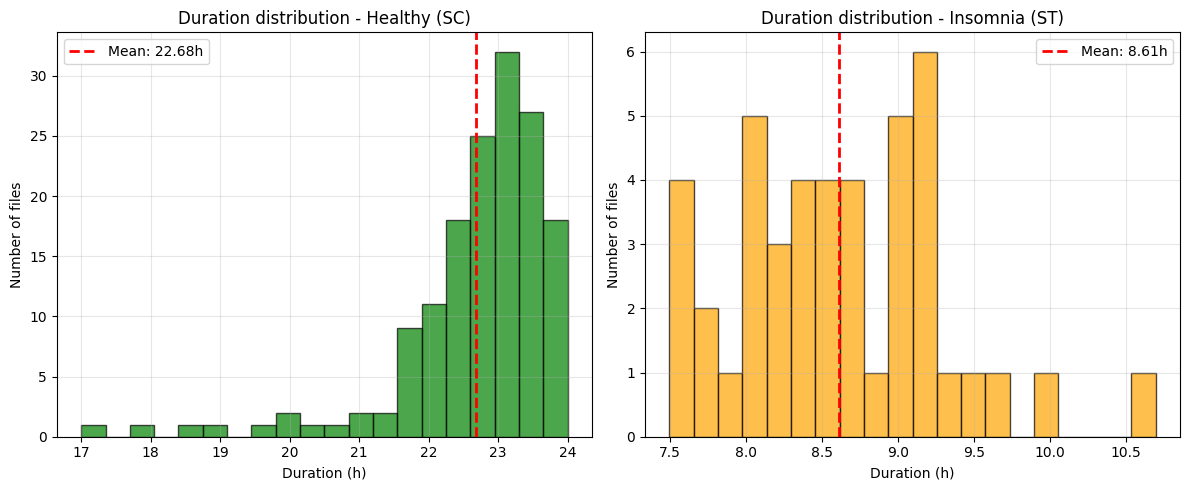

In [ ]:
healthy_results = inspect_psg_files(psg_paths=healthy_matched_df,  dataset_name="Healthy", base_path=base_path + 'raw_dataset/', enable_prints=False)
insomnia_results = inspect_psg_files(psg_paths=insomnia_matched_df,  dataset_name="Insomnia", base_path=base_path + 'raw_dataset/', enable_prints=False)
compare_psg_datasets(healthy_results, insomnia_results, "Healthy (SC)", "Insomnia (ST)")

What the data tells us:
* SC Set (Healthy): Contains ~22-24 hours of PSG recordings (full 24h recordings)
* 153 files
* Average: 22.68 hours (about a full day)
* Probably includes both waking and sleeping periods
* Important: Hypnograms for SC only cover the sleep period (8h), not the entire 24h recording!

* ST Set (Insomnia): Contains ~8 hours of PSG recordings (night sleep)
* 44 files
* Average: 8.61 hours (night sleep)
* Focused on sleep period only

Critical conclusion for visualization:
The hypnograms in the SC set are detailed only for the sleep period (~8h), even though the PSG records 24h. This means that:
* For SC: PSG is 24h, but hypnogram is only ~8h (corresponding to the sleep period)
* ​​For ST: PSG and hypnogram are both ~8h (perfect match)

The correct visualization strategy:
You should:
* For SC: We visualize only the segment corresponding to the hypnogram (the first ~8h)
* For ST: We visualize the entire recording (which is already ~8h)

In [ ]:
def analyze_channels_across_files(psg_paths, base_path=None, max_files=20):
    '''Analyze common and unique channels across multiple PSG (Polysomnography) files.

    Parameters:
        - psg_paths (list): List of PSG file paths.
        - base_path (str, optional): Base path to prepend if file paths are relative.
        - max_files (int, optional): Maximum number of files to analyze (default = 20).
    '''
    # Apply base_path if provided
    if base_path:
        psg_paths = [p.replace('{base_path}', base_path) if isinstance(p, str) else p for p in psg_paths]

    # Limit number of files if max_files is set
    if len(psg_paths) > max_files:
        psg_paths = psg_paths[:max_files]

    all_channels = []   # Collect all channels across files
    channel_sets = []   # Store channel sets per file

    for i, psg_path in enumerate(psg_paths):
        try:
            # Load PSG file using MNE
            raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
            channels = set(raw.ch_names)

            # Add channels to global lists
            all_channels.extend(raw.ch_names)
            channel_sets.append(channels)

        except Exception as e:
            print(f"Error loading {psg_path}: {e}")

    if channel_sets:
        # Find channels common to all files
        common_channels = set.intersection(*channel_sets)
        print(f"\nCommon channels in all files ({len(common_channels)}):")
        for ch in sorted(common_channels):
            print(f"  - {ch}")

        # Find all unique channels across files
        all_unique_channels = set(all_channels)
        print(f"\nTotal unique channels in all files: {len(all_unique_channels)}")

        # Count frequency of channels across files
        from collections import Counter
        channel_counter = Counter(all_channels)
        print(f"Top 10 most frequent channels:")
        for channel, count in channel_counter.most_common(10):
            percentage = (count / len(psg_paths)) * 100
            print(f"  {channel}: {count} files ({percentage:.1f}%)")

analyze_channels_across_files(healthy_matched_df['psg_path'].tolist(),base_path + 'raw_dataset/')


Common channels in all files (7):
  - EEG Fpz-Cz
  - EEG Pz-Oz
  - EMG submental
  - EOG horizontal
  - Event marker
  - Resp oro-nasal
  - Temp rectal

Total unique channels in all files: 7
Top 10 most frequent channels:
  EEG Fpz-Cz: 20 files (100.0%)
  EEG Pz-Oz: 20 files (100.0%)
  EOG horizontal: 20 files (100.0%)
  Resp oro-nasal: 20 files (100.0%)
  EMG submental: 20 files (100.0%)
  Temp rectal: 20 files (100.0%)
  Event marker: 20 files (100.0%)


Important notes:
1. Channel uniformity:
* All SC (Healthy) files have exactly the same 7 channels - perfectly uniform structure
* All files have the same channels in 100% of cases - no file is missing a channel

2. Available channels:
* Essential channels for sleep scoring (4 channels):
* EEG Fpz-Cz - Frontal-central derivation (for delta/theta waves)
* EEG Pz-Oz - Parietal-occipital derivation (for alpha/spindles waves)
* Horizontal EOG - Eye movements (for REM and blinks)
* Submental EMG - Muscle tone (low in REM)
* Additional channels for monitoring (3 channels):
* Oro-nasal resp - Respiratory flow (for apnea detection)
* Rectal temp - Body temperature (for circadian rhythm)
* Event marker - Event marker (wings, apnea, etc.)

For ST set (Insomnia):
* It only has 5 channels (no oro-nasal Respiration and rectal temp)
* The marker may have different names
* However, it has all 4 essential channels for sleep scoring

These issues will be resolved in ETL

#Visualisation Healthy

In [ ]:
def visualize_recording(df, row_index, window_duration=30):
    '''Visualize EDF signals and annotations for a specific subject recording.

    Parameters:
        - df (DataFrame): DataFrame containing 'psg_path', 'hypno_path', and 'id' columns.
        - row_index (int): Index of the row to visualize.
        - window_duration (int, optional): Duration (in seconds) of the window to display (default = 30).
    '''

    # 1. Extract file paths from DataFrame
    try:
        row = df.iloc[row_index]
        psg_path = row['psg_path']
        hypno_path = row['hypno_path']
        subject_id = row['id']
    except IndexError:
        print(f"Error: Row index {row_index} is out of bounds.")
        return
    except KeyError as e:
        print(f"Error: DataFrame is missing column {e}")
        return

    print(f"Visualize Recording: {subject_id}")

    try:
        # 2. Load raw PSG signals
        raw = mne.io.read_raw_edf(psg_path, preload=True)

        # 3. Load hypnogram annotations
        annot = mne.read_annotations(hypno_path)

        # 4. Attach annotations to raw signals
        raw.set_annotations(annot, emit_warning=False)

        # 5. Setup visualization
        channel_names = raw.ch_names
        print(f"Available channels: {channel_names}")

        # Define colors for sleep stages and events
        annotation_colors = {
            'Sleep stage W': 'orange',     # Wake
            'Sleep stage 1': 'lightblue',  # N1 (drowsiness)
            'Sleep stage 2': 'royalblue',  # N2 (light sleep)
            'Sleep stage 3': 'darkblue',   # N3 (deep sleep)
            'Sleep stage 4': 'darkblue',   # N3 (legacy label)
            'Sleep stage R': 'red',        # REM sleep
            'Movement time': 'green',      # Movement artifacts
            'Unknown': 'gray'              # Unclassified segments
        }

        # Convert annotations to events
        events, event_id = mne.events_from_annotations(raw)

        # Map integer event IDs to colors
        plot_event_colors = {}
        for label, code in event_id.items():
            if label in annotation_colors:
                plot_event_colors[code] = annotation_colors[label]

        # 6. Plot signals with annotations
        raw.plot(
            duration=window_duration,
            scalings='auto',
            title=f"Recording: {subject_id}",
            show_options=True,
            n_channels=len(channel_names),
            events=events,
            event_color=plot_event_colors,
            event_id=event_id,
            block=True
        )

    except FileNotFoundError:
        print("Error: One of the files was not found at the specified path.")
    except Exception as e:
        print(f"An error occurred: {e}")

Visualize Recording: SC4001
Extracting EDF parameters from /content/drive/MyDrive/sleep_data/raw_dataset/SC_healthy_psg/SC4001E0-PSG.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Available channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Using matplotlib as 2D backend.


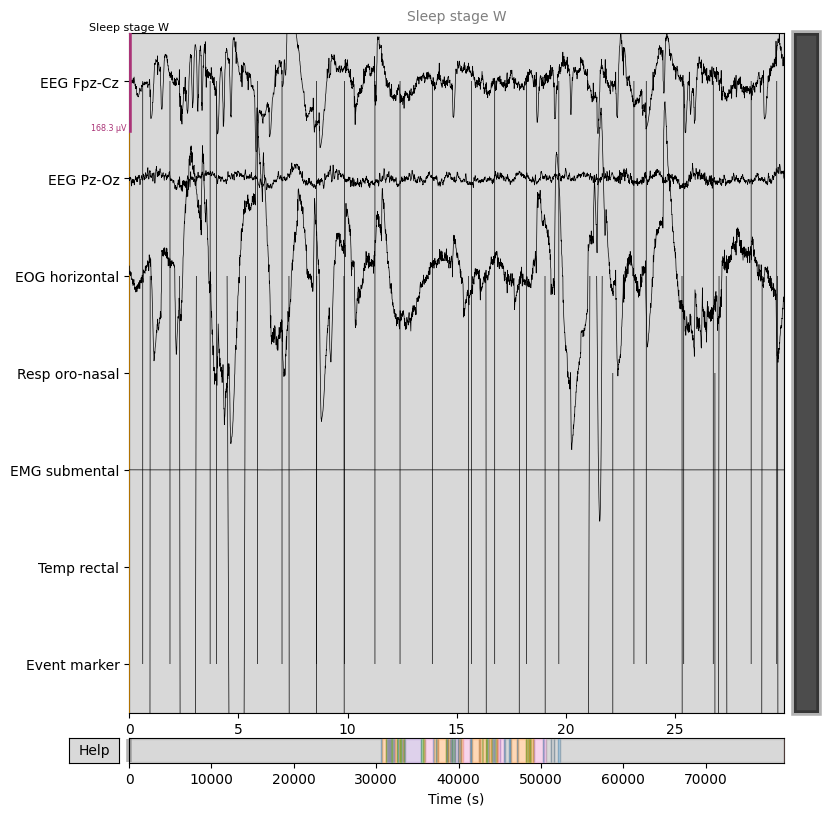

In [ ]:
visualize_recording(healthy_matched_df, 0)

Visualize Recording: ST7011
Extracting EDF parameters from /content/drive/MyDrive/sleep_data/raw_dataset/ST_insomnia_psg/ST7011J0-PSG.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...
Available channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


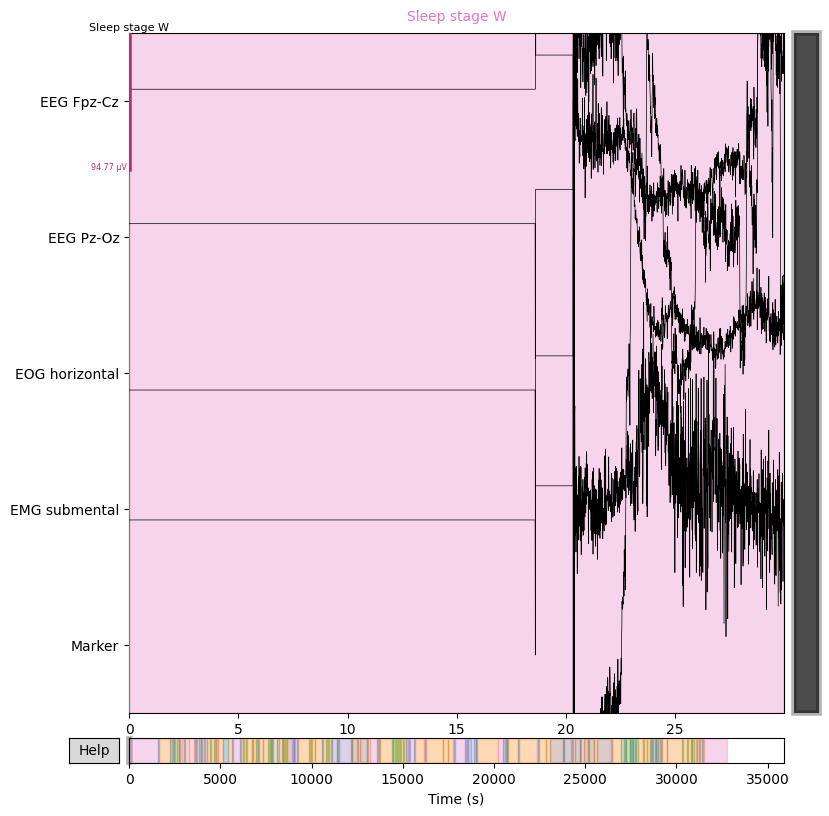

In [ ]:
visualize_recording(insomnia_matched_df, 0)

1. Main Graph (Top, large area)
* This is the **real-time signal viewer** (or navigation window).
* Shows the electrical activity recorded by the sensors for a specific "epoch" of time (in your case, a **30 second** window, defined by `window_duration=30`).
* **Axes:**
* **Y-Axis (Vertical):** Names of the channels (sensors).
* `EEG Fpz-Cz`, `EEG Pz-Oz`: Brain activity (brain waves).
* `EOG horizontal`: Eye movement.
* `Oronasal Resp`: Breathing.
* `Submental EMG`: Muscle tone (chin).
* `Event marker`: A technical channel for markers.
* **X-Axis (Horizontal):** Time in seconds (from 0 to 30).
* **Pink Background and "Sleep stage W" Text:**
* MNE colors the background to show the current **Annotation**.
* The **"Sleep stage W"** (Wake) text at the top indicates that, during these 30 seconds, the patient was classified as **Awake**.

2. Secondary Graph (Narrow Bottom Bar)
* This is the **Overview bar**.
* Shows the **entire recording duration** (the entire night's sleep, approx. 80,000 seconds in this case).
* **Colored Stripes** Represent the visual "Hypnogram". Each colored stripe corresponds to a sleep stage (W, N1, N2, N3, REM) at that time.
* **Light Gray Area/Highlight:** That small rectangle or lighter area indicates **where you are now** with the large graph. By moving that area, you can walk through the recording.

3. What do the colors mean?
The colors are defined by you in the `annotation_colors` dictionary. They will appear as vertical lines (events) on the large graph or as stripes on the bottom bar:

* **Orange (`Sleep stage W`):** **Wake**. The patient is conscious.
* **Lightblue (`Sleep stage 1`):** **N1 (Drowsiness)**. The transition between wakefulness and sleep.
* **Royalblue (`Sleep stage 2`):** **N2 (Light sleep)**. This is where we spend most of the night.
* **Darkblue (`Sleep stage 3` / `4`):** **N3 (Deep sleep)**. This is regenerative sleep.
* **Red (`Sleep stage R`):** **REM (Rapid Eye Movement)**. The stage where we dream most intensely (high brain activity, but paralyzed muscles).
* **Green (`Movement time`):** Moments when the patient physically moved, creating "artifacts" on the sensors.
* **Gray (`Unknown`):** Portions where the device could not classify sleep (possibly lost signal).

**Why are the two images so different?**

The major difference comes from the fact that the two files come from two completely different subsets of the Sleep-EDF database, which have distinct purposes and technical qualities.

1. SC4212 ("SC" Set - Sleep Cassette)
  * Origin: This subset contains data from healthy volunteers, monitored at home using portable systems (cassette recorder).
  * Clean Signal: The lines are clear, distinct. You can see the real biological rhythm.
  * Minimal Artifacts: Although there are fluctuations, they appear to be physiological (blinking, breathing).
  * Extra Channels: Includes breathing (Oronasal Resp) and rectal temperature, which helps in a more accurate scoring of apnea or circadian rhythm.
  * Conclusion: This is an "ideal", reference recording, easy to read by algorithms and humans.

2. ST7112 (Set "ST" - Sleep Telemetry)
  * Origin: This subset comes from a 1994 clinical study on the effects of the drug Temazepam on sleep. The subjects had mild difficulty falling asleep (mild insomnia), and the recordings were made in the hospital.
  * Massive Noise: Notice those dense black blocks in the EEG and EOG channels? This is "saturation" or strong motion artifacts. Since the subject is awake (Stage W) and possibly agitated (insomnia), he is moving a lot, which completely distorts the electrical signal.
  * Clipping: The signal is so strong that it goes off scale (thick black vertical lines).
  * Missing Channels: It does not have the respiration or temperature sensors, as the study protocol focused only on the effect of the drug on sleep architecture (EEG), not respiration.
  * Conclusion: This is a "difficult" recording. If you are training a neural network, this type of noisy data can confuse the model if it is not pre-processed (cleaned/filtered).

##View only EEG and Hypno

In [14]:
psg_file = base_path + '/SC_healthy_psg/SC4002E0-PSG.edf'
hyp_file = base_path + '/SC_healthy_hypno/SC4002EC-Hypnogram.edf'

Extracting EDF parameters from /content/SC4002E0-PSG.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3446999  =      0.000 ... 34469.990 secs...
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


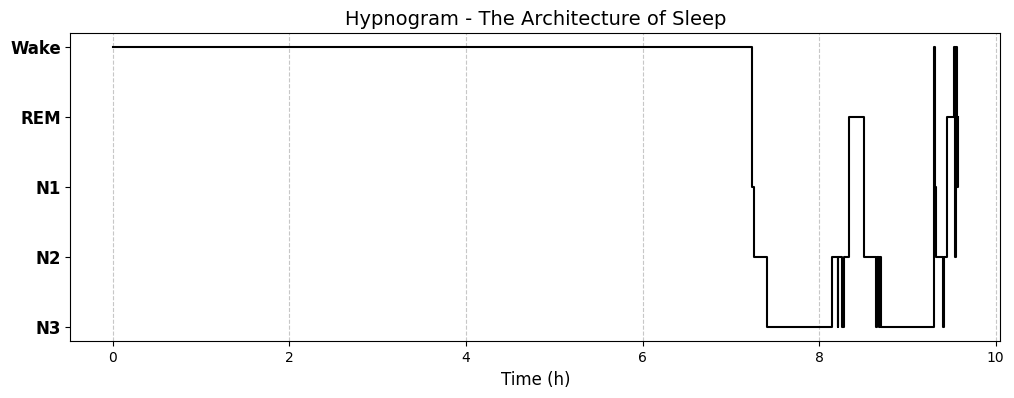

In [15]:
raw = mne.io.read_raw_edf(psg_file, preload=True)
annot = mne.read_annotations(hyp_file)
raw.set_annotations(annot, emit_warning=False)

events, event_id = mne.events_from_annotations(raw, event_id={
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3, # N4 -> N3
    'Sleep stage R': 4
})

times = events[:, 0] / raw.info['sfreq'] / 3600
y_values = events[:, 2]

# Standard: W=0, R=1, N1=2, N2=3, N3=4
display_map = {0: 0, 4: 1, 1: 2, 2: 3, 3: 4}
y_plot = [display_map[y] if y in display_map else None for y in y_values]

fig, ax = plt.subplots(figsize=(12, 4))
ax.step(times, y_plot, where='post', color='black', linewidth=1.5)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['Wake', 'REM', 'N1', 'N2', 'N3'], fontsize=12, fontweight='bold')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_title('Hypnogram - The Architecture of Sleep', fontsize=14)
ax.invert_yaxis() # We reverse the Y axis so that W is up
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 s)



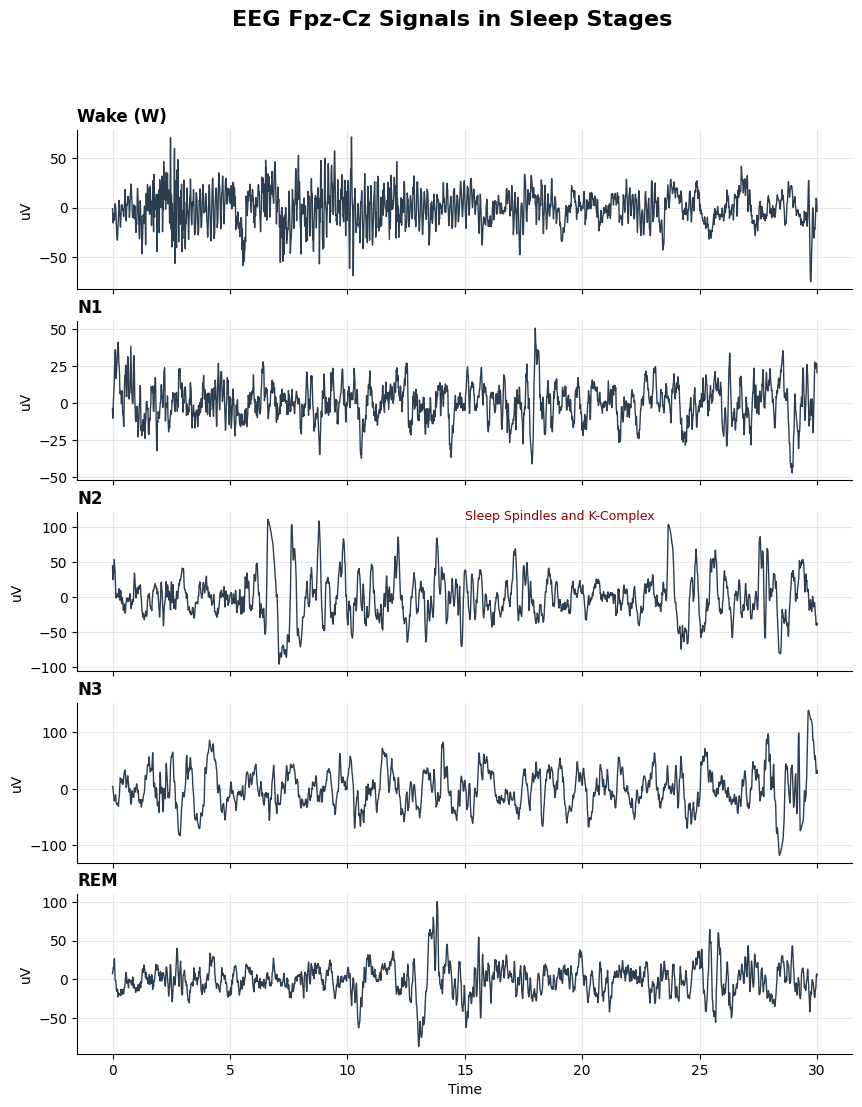

In [18]:
channel_name = 'EEG Fpz-Cz'
stages_to_plot = {
    'Sleep stage W': 'Wake (W)',
    'Sleep stage 1': 'N1',
    'Sleep stage 2': 'N2',
    'Sleep stage 3': 'N3',
    'Sleep stage R': 'REM'
}

raw_plot = raw.copy().filter(0.5, 30)

fig, axes = plt.subplots(len(stages_to_plot), 1, figsize=(10, 12), sharex=True)
fig.suptitle('EEG Fpz-Cz Signals in Sleep Stages', fontsize=16, fontweight='bold')

for i, (stage_key, stage_label) in enumerate(stages_to_plot.items()):
    found_annot = [a for a in raw.annotations if a['description'] == stage_key]

    if found_annot:
        idx_to_pick = 2 if len(found_annot) > 2 else 0
        candidate_start_time = found_annot[idx_to_pick]['onset']

        if candidate_start_time + 30 > raw_plot.times[-1]:
            valid_start_time = None
            for j in range(len(found_annot) - 1, -1, -1):
                current_onset = found_annot[j]['onset']
                if current_onset + 30 <= raw_plot.times[-1]:
                    valid_start_time = current_onset
                    break

            if valid_start_time is not None:
                start_time = valid_start_time
            else:
                print(f"  Warning: No suitable 30s segment found for '{stage_label}' within recording limits. Skipping this stage.")
                continue
        else:
            start_time = candidate_start_time

        # Extract 30 s
        segment = raw_plot.copy().crop(tmin=start_time, tmax=start_time + 30)
        data, times = segment[channel_name]
        times = times - times[0]

        # data[0] because MNE returns (n_channels, n_times)
        axes[i].plot(times, data[0] * 1e6, color='#2c3e50', linewidth=1)
        axes[i].set_title(stage_label, loc='left', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('uV')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].grid(alpha=0.3)

        if 'N2' in stage_label:
             axes[i].text(15, np.max(data[0])*1e6, 'Sleep Spindles and K-Complex', color='darkred', fontsize=9)

axes[-1].set_xlabel('Time')
plt.show()

#Save results

In [ ]:
healthy_matched_df['study'] = 'SC (healthy)'
insomnia_matched_df['study'] = 'ST (insomnia)'

all_matched_df = pd.concat([healthy_matched_df, insomnia_matched_df], ignore_index=True)
print(f"Healthy records = {len(healthy_matched_df)}")
print(f"Insomnia records = {len(insomnia_matched_df)}")
print(f"Total records = {len(all_matched_df)}")

Healthy records = 153
Insomnia records = 44
Total records = 197


In [ ]:
all_matched_df.to_csv(base_path + '/full_paths.csv', index=False)

---
# Conclusions and Next Step

In this notebook we identified:
1. Corrupted hypnogram files in the ST dataset.
2. Discrepancies between the two studies for the PSG files:
  * the SC study has more recordings than during sleep
  * the SC study also has more channels than the ST

The next step in the pipeline is [**Extract, Tranform, Load**](https://colab.research.google.com/drive/1REGt22k8LiXCseev4EBROStRsDNQVaLT?usp=sharing)